In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt

import copy

from utility import MNIST_AE, make_train_step, train, test

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
classes_trained_on = range(10)

train_dataset = MNIST_AE(training_data=True, classes=classes_trained_on, noise_mean=5, noise_std=2)
test_dataset = MNIST_AE(training_data=False, classes=classes_trained_on, noise_mean=5, noise_std=2)

In [4]:
class ConvAE(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # Conv 1
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(5, 5))
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.relu1 = torch.nn.ReLU()

        # Max pool 1
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, return_indices=True)

        # Conv 2
        self.conv2 = torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(5, 5))
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.relu2 = torch.nn.ReLU()

        # TODO: Add feedforward layers

        # Deconv 1
        self.deconv1 = torch.nn.ConvTranspose2d(in_channels=20, out_channels=10, kernel_size=(5, 5))
        torch.nn.init.xavier_uniform_(self.deconv1.weight)
        self.relu3 = torch.nn.ReLU()

        # Max Unpool 1
        self.maxunpool1 = torch.nn.MaxUnpool2d(kernel_size=2)

        # Deconv 2
        self.deconv2 = torch.nn.ConvTranspose2d(in_channels=10, out_channels=1, kernel_size=(5, 5))
        torch.nn.init.xavier_uniform_(self.deconv2.weight)
        self.relu4 = torch.nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)

        size1 = out.size()
        out, indices1 = self.maxpool1(out)

        out = self.conv2(out)
        out = self.relu2(out)

        out = self.deconv1(out)
        out = self.relu3(out)

        out = self.maxunpool1(out, indices=indices1)

        out = self.deconv2(out)
        out = self.relu4(out)

        return out


model = ConvAE().to(device)

untrained_model = ConvAE().to(device)
untrained_model.load_state_dict(copy.deepcopy(model.state_dict()))

<All keys matched successfully>

In [5]:
nb_epochs = 10

lr = 2e-4
momentum = 0.7
loss_reduction='mean'

train_batch_size = 60
test_batch_size = 120

log_interval = 60

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_step = make_train_step(model, loss_fn, optimizer)

In [6]:
train_losses = []
train_accuracies = []
train_counter = []

test_losses = []
test_accuracies = []
test_counter = []

epoch = 1
last_epoch = 1

In [17]:
# If model hasn't been trained yet, do a test (as a reference)
if last_epoch == 1:
    test(model, loss_fn, test_loader, test_losses, 0)
    test_counter.append(0)

for epoch in range(last_epoch, last_epoch + nb_epochs):
    # Train
    train(train_step, train_loader, train_losses, train_counter, epoch, log_interval, train_batch_size)
    
    # Test
    test(model, loss_fn, test_loader, test_losses, epoch)
    test_counter.append(epoch * len(train_loader.dataset))
            
last_epoch = epoch

Training epoch #5 (60/ 60000) (0%) - Loss = 0.347660
Training epoch #5 (3660/ 60000) (6%) - Loss = 0.334305
Training epoch #5 (7260/ 60000) (12%) - Loss = 0.323789
Training epoch #5 (10860/ 60000) (18%) - Loss = 0.337536
Training epoch #5 (14460/ 60000) (24%) - Loss = 0.330185
Training epoch #5 (18060/ 60000) (30%) - Loss = 0.332207
Training epoch #5 (21660/ 60000) (36%) - Loss = 0.319982
Training epoch #5 (25260/ 60000) (42%) - Loss = 0.332146
Training epoch #5 (28860/ 60000) (48%) - Loss = 0.330169
Training epoch #5 (32460/ 60000) (54%) - Loss = 0.322704
Training epoch #5 (36060/ 60000) (60%) - Loss = 0.327595
Training epoch #5 (39660/ 60000) (66%) - Loss = 0.319844
Training epoch #5 (43260/ 60000) (72%) - Loss = 0.328011
Training epoch #5 (46860/ 60000) (78%) - Loss = 0.322453
Training epoch #5 (50460/ 60000) (84%) - Loss = 0.333115
Training epoch #5 (54060/ 60000) (90%) - Loss = 0.326519
Training epoch #5 (57660/ 60000) (96%) - Loss = 0.316673

Test epoch #5 - Avg. loss = 0.325302


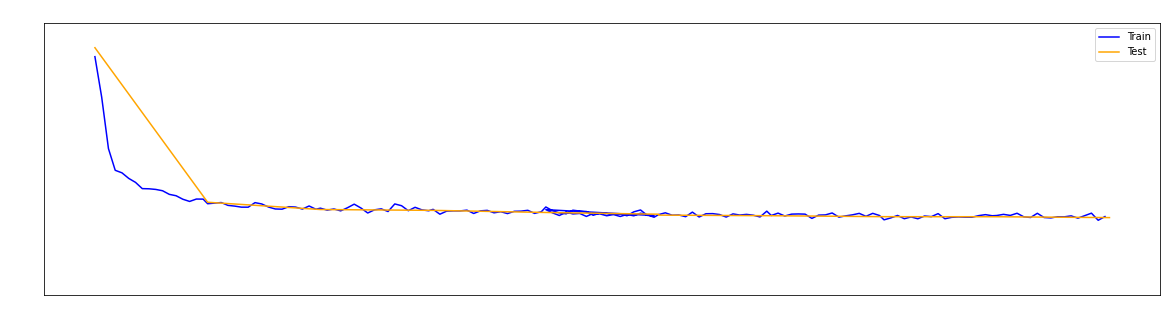

In [18]:
plt.figure(figsize=(20, 5))

plt.plot(train_counter, train_losses, color='blue', label='Train')
plt.plot(test_counter, test_losses, color='orange', label='Test')

plt.setp(plt.title("Train/Test loss per # of images trained on"), color='white')
plt.setp(plt.xlabel("# of images trained on"), color='white')
plt.setp(plt.ylabel("MSE Loss"), color='white')

plt.legend(loc='upper right')

plt.ylim([0, max(train_losses + test_losses) * 1.1])

plt.tick_params(colors='white')

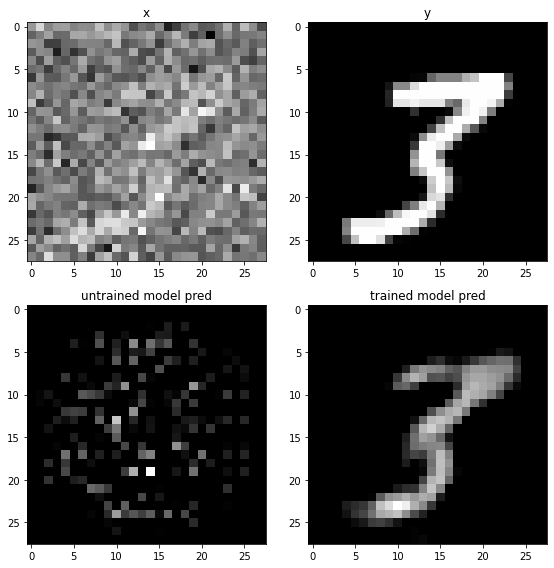

In [26]:
data = test_dataset

i = np.random.randint(0, len(data))

x = data[i][0].to(device)
y = data[i][1]

y_hat_trained = model(torch.unsqueeze(x, dim=0))[0]
y_hat_untrained = untrained_model(torch.unsqueeze(x, dim=0))[0]

x, y_hat_trained, y_hat_untrained = x.to('cpu'), y_hat_trained.detach().to('cpu'), y_hat_untrained.detach().to('cpu')

plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.title('x')
plt.imshow(x, cmap="gray")

plt.subplot(222)
plt.title('y')
plt.imshow(y, cmap="gray")

plt.subplot(223)
plt.title('untrained model pred')
plt.imshow(y_hat_untrained, cmap="gray")

plt.subplot(224)
plt.title('trained model pred')
plt.imshow(y_hat_trained, cmap="gray")

plt.tight_layout()